In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [120]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

In [121]:
df = pd.read_csv("adult.csv")

In [122]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [123]:
df.replace('?', np.nan, inplace=True)

In [124]:
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [125]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64']).columns.tolist()

categorical_features, numerical_features

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country',
  'income'],
 ['age',
  'fnlwgt',
  'educational-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'])

In [126]:
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])

df['income'].value_counts()


,count
income,
0,34014
1,11208


In [127]:
X = df.drop('income', axis=1)
y = df['income']

categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64']).columns


In [128]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_encoded = preprocessor.fit_transform(X)


In [129]:
scaler = StandardScaler()

X_num_scaled = scaler.fit_transform(X[numerical_cols])

X_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
).fit_transform(X)


In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

model_unscaled = LogisticRegression(max_iter=1000)
model_unscaled.fit(X_train, y_train)

y_pred_unscaled = model_unscaled.predict(X_test)
accuracy_unscaled = accuracy_score(y_test, y_pred_unscaled)

accuracy_unscaled


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8423438363736871

In [131]:
X_train_s, X_test_s, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model_scaled = LogisticRegression(max_iter=1000)
model_scaled.fit(X_train_s, y_train)

y_pred_scaled = model_scaled.predict(X_test_s)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

accuracy_scaled


0.8518518518518519

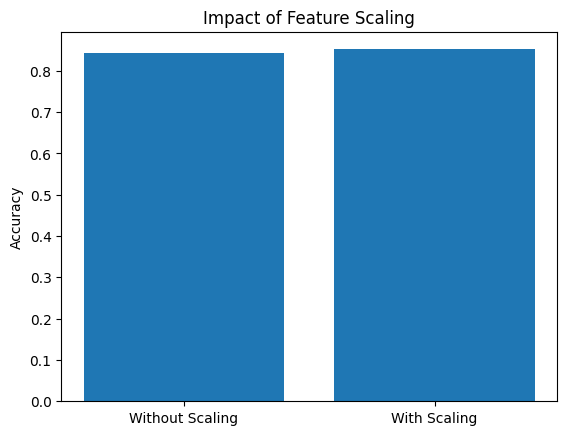

In [132]:
plt.bar(['Without Scaling', 'With Scaling'],
        [accuracy_unscaled, accuracy_scaled])
plt.ylabel('Accuracy')
plt.title('Impact of Feature Scaling')
plt.show()


In [133]:
encoded_feature_names = (
    numerical_cols.tolist() +
    list(preprocessor.named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

processed_df = pd.DataFrame(X_scaled.toarray(), columns=encoded_feature_names)
processed_df['income'] = y.values

processed_df.to_csv("adult_income_preprocessed.csv", index=False)

processed_df.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,-1.024983,0.350889,-1.221559,-0.146733,-0.21878,-0.078120,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.041455,-0.945878,-0.438122,-0.146733,-0.21878,0.754701,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.798015,1.393592,0.737034,-0.146733,-0.21878,-0.078120,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,0.412481,-0.278420,-0.046403,0.877467,-0.21878,-0.078120,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,-0.344079,0.084802,-1.613277,-0.146733,-0.21878,-0.910942,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
